In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from scipy.stats import chi2_contingency
df = pd.read_csv('census_data.csv')

#### Understanding the data

1) Basic info:

In [3]:
print(f'data type: {df.dtypes.value_counts()}')

data type: object     29
int64      12
float64     1
Name: count, dtype: int64


In [4]:
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
print(f' missing values: {missing_data}')

 missing values: hispanic origin    874
dtype: int64


2) check label value

In [5]:
print(f'label value types: {df["label"].value_counts()}')
df['target'] = (~df['label'].str.contains('- 50000', na=False)).astype(int)
print(f'label value types(binary): {df["target"].value_counts()}')

label value types: label
- 50000.    187141
50000+.      12382
Name: count, dtype: int64
label value types(binary): target
0    187141
1     12382
Name: count, dtype: int64


In [6]:
# distribution
target_counts = df['target'].value_counts()
print(f"≤$50K (0): {target_counts[0]:,} ({target_counts[0]/len(df)*100:.2f}%)")
print(f">$50K (1): {target_counts[1]:,} ({target_counts[1]/len(df)*100:.2f}%)")
imbalance_ratio = target_counts[0] / target_counts[1]
print(f"Imbalance Ratio: {imbalance_ratio:.2f}:1")

≤$50K (0): 187,141 (93.79%)
>$50K (1): 12,382 (6.21%)
Imbalance Ratio: 15.11:1


The data is really scaled, we need to handle the imbalanced data otherwise if the model is just guessing ≤$50K the accuracy will be ~90%

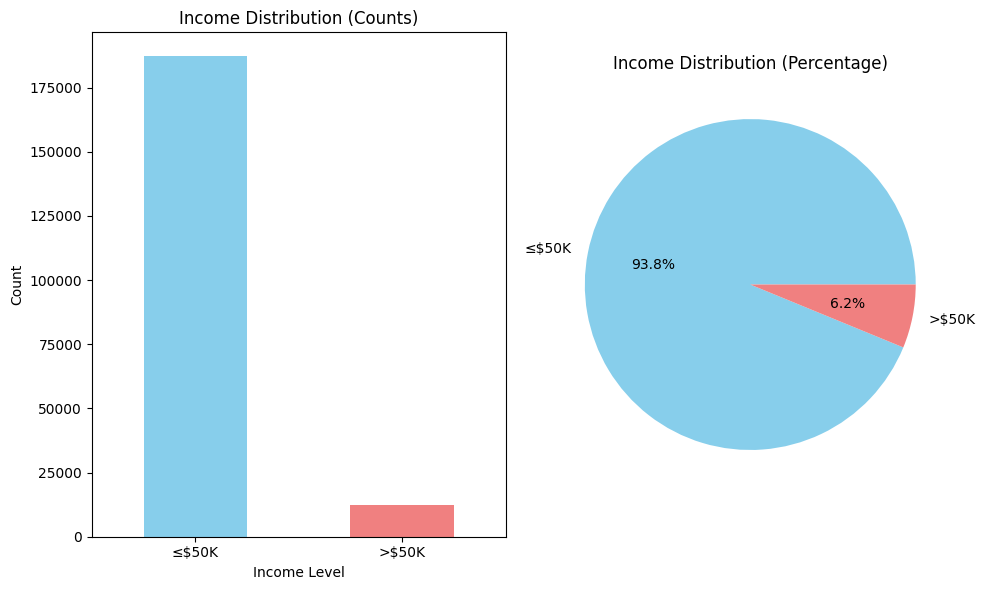

In [7]:
# visualize target distribution
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
target_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Income Distribution (Counts)')
plt.xlabel('Income Level')
plt.ylabel('Count')
plt.xticks([0, 1], ['≤$50K', '>$50K'], rotation=0)

plt.subplot(1, 2, 2)
plt.pie(target_counts.values, labels=['≤$50K', '>$50K'], autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Income Distribution (Percentage)')

plt.tight_layout()
plt.savefig('target_distribution.png')
plt.show()

3. understanding categorical features

In [8]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'label']
print(f'categorical_cols: {categorical_cols}')

categorical_cols: ['class of worker', 'education', 'enroll in edu inst last wk', 'marital stat', 'major industry code', 'major occupation code', 'race', 'hispanic origin', 'sex', 'member of a labor union', 'reason for unemployment', 'full or part time employment stat', 'tax filer stat', 'region of previous residence', 'state of previous residence', 'detailed household and family stat', 'detailed household summary in household', 'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'live in this house 1 year ago', 'migration prev res in sunbelt', 'family members under 18', 'country of birth father', 'country of birth mother', 'country of birth self', 'citizenship', "fill inc questionnaire for veteran's admin"]


In [9]:
categorical_analysis = {}
# check all the data distribution in the categorical data 
for col in categorical_cols:
    unique_values = df[col].nunique()
    most_common = df[col].value_counts()
    categorical_analysis[col] = {'unique_count': unique_values,'most_common': most_common}
    
    print(f"\n{col}:")
    print(f"Unique values: {unique_values}")
    print(f"values:")
    for val, count in most_common.items():
        print(f"    {val}: {count:,} ({count/len(df)*100:.2f}%)")
    


class of worker:
Unique values: 9
values:
    Not in universe: 100,245 (50.24%)
    Private: 72,028 (36.10%)
    Self-employed-not incorporated: 8,445 (4.23%)
    Local government: 7,784 (3.90%)
    State government: 4,227 (2.12%)
    Self-employed-incorporated: 3,265 (1.64%)
    Federal government: 2,925 (1.47%)
    Never worked: 439 (0.22%)
    Without pay: 165 (0.08%)

education:
Unique values: 17
values:
    High school graduate: 48,407 (24.26%)
    Children: 47,422 (23.77%)
    Some college but no degree: 27,820 (13.94%)
    Bachelors degree(BA AB BS): 19,865 (9.96%)
    7th and 8th grade: 8,007 (4.01%)
    10th grade: 7,557 (3.79%)
    11th grade: 6,876 (3.45%)
    Masters degree(MA MS MEng MEd MSW MBA): 6,541 (3.28%)
    9th grade: 6,230 (3.12%)
    Associates degree-occup /vocational: 5,358 (2.69%)
    Associates degree-academic program: 4,363 (2.19%)
    5th or 6th grade: 3,277 (1.64%)
    12th grade no diploma: 2,126 (1.07%)
    1st 2nd 3rd or 4th grade: 1,799 (0.90%)
    Pr

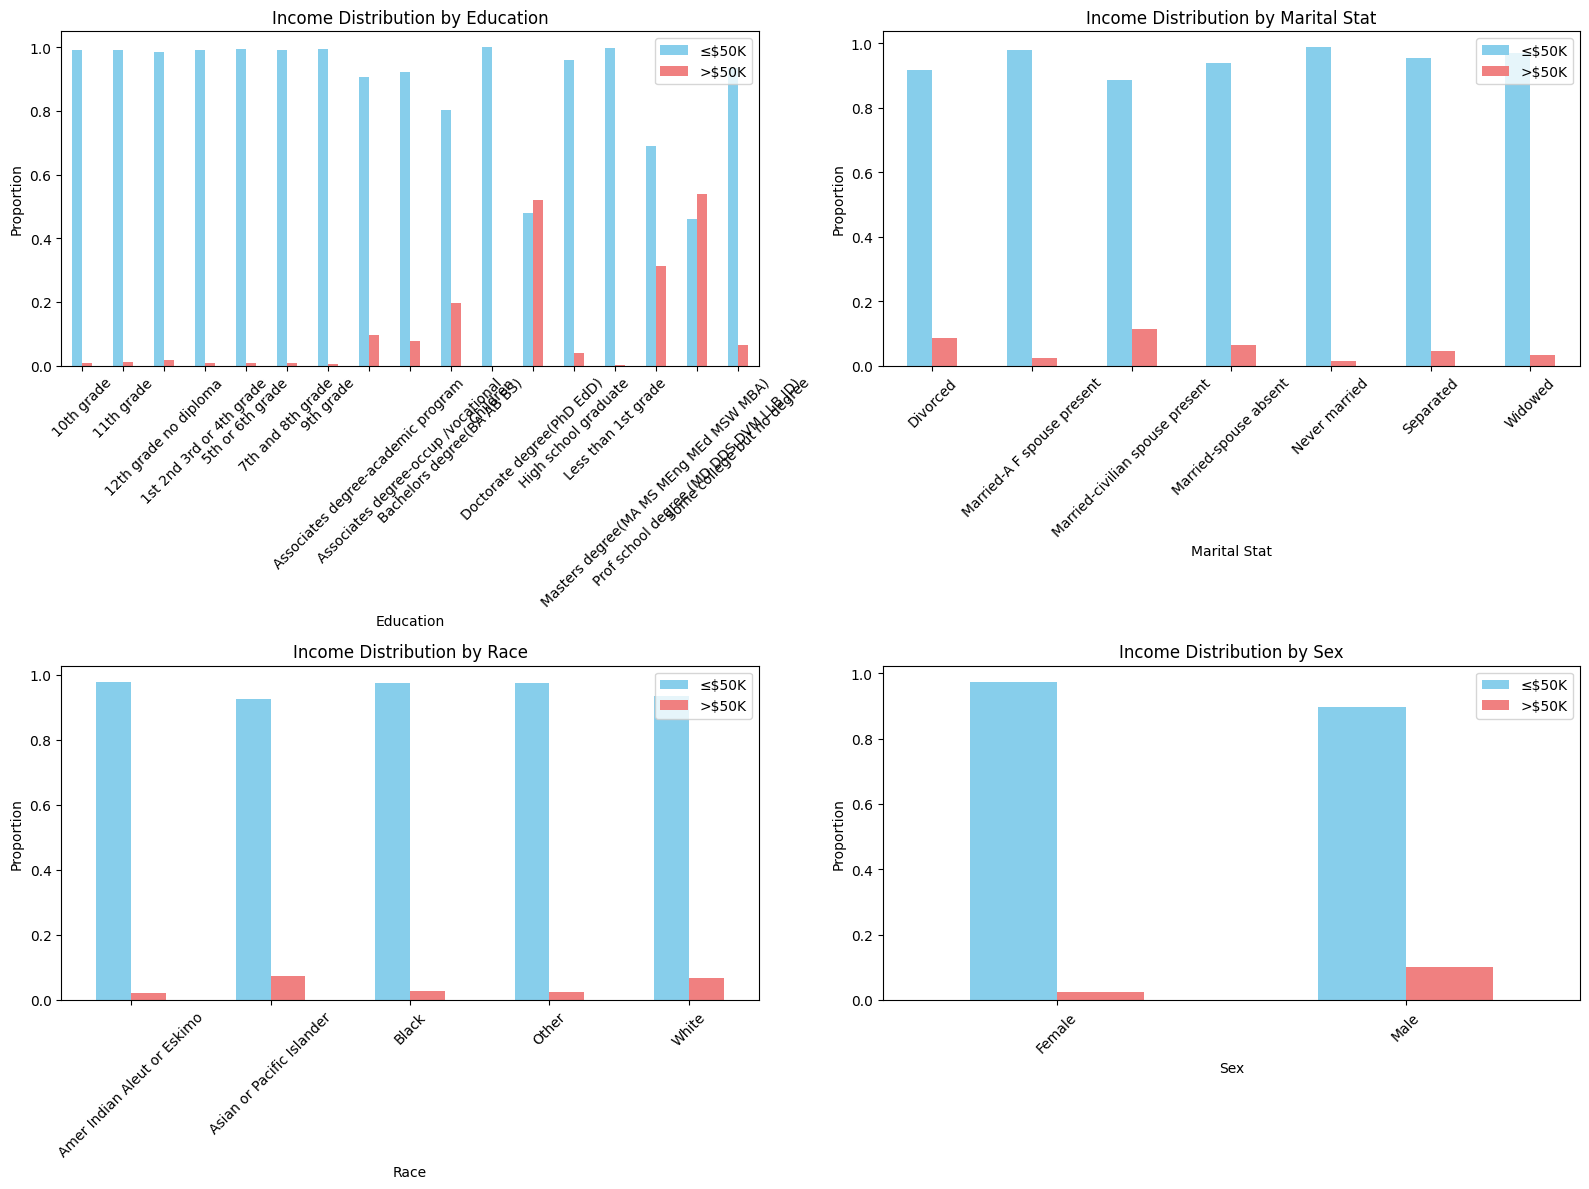

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

key_features = ['education', 'marital stat', 'race', 'sex']
    
for i, col in enumerate(key_features):
    if col in df.columns:
        crosstab = pd.crosstab(df[col], df['target'], normalize='index')
        crosstab.plot(kind='bar', ax=axes[i], stacked=False, 
                        color=['skyblue', 'lightcoral'])
        axes[i].set_title(f'Income Distribution by {col.title()}')
        axes[i].set_xlabel(col.title())
        axes[i].set_ylabel('Proportion')
        axes[i].legend(['≤$50K', '>$50K'])
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

4) analyze numerical features

In [11]:
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ['target']]
print(f'numerical_cols : {numerical_cols}')

numerical_cols : ['age', 'detailed industry recode', 'detailed occupation recode', 'wage per hour', 'capital gains', 'capital losses', 'dividends from stocks', 'weight', 'num persons worked for employer', 'own business or self employed', 'veterans benefits', 'weeks worked in year', 'year']


In [12]:
print(f"Statistics:")
df[numerical_cols].describe()

Statistics:


,age,detailed industry recode,detailed occupation recode,wage per hour,capital gains,capital losses,dividends from stocks,weight,num persons worked for employer,own business or self employed,veterans benefits,weeks worked in year,year
count,199523.000000,199523.000000,199523.000000,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494199,15.352320,11.306556,55.426908,434.71899,37.313788,197.529533,1740.380269,1.956180,0.175438,1.514833,23.174897,94.499672
std,22.310895,18.067129,14.454204,274.896454,4697.53128,271.896428,1984.163658,993.768156,2.365126,0.553694,0.851473,24.411488,0.500001
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,37.870000,0.000000,0.000000,0.000000,0.000000,94.000000
25%,15.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1061.615000,0.000000,0.000000,2.000000,0.000000,94.000000
50%,33.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1618.310000,1.000000,0.000000,2.000000,8.000000,94.000000
75%,50.000000,33.000000,26.000000,0.000000,0.00000,0.000000,0.000000,2188.610000,4.000000,0.000000,2.000000,52.000000,95.000000
max,90.000000,51.000000,46.000000,9999.000000,99999.00000,4608.000000,99999.000000,18656.300000,6.000000,2.000000,2.000000,52.000000,95.000000


will be using "major occupation code", which is corelated with "detailed occupation recode"

In [13]:
# encode categorical variables for correlation analysis
df_encoded = df.copy()
le = LabelEncoder()

categorical_cols = df_encoded.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'label']

for col in categorical_cols:
    df_encoded[col] = df_encoded[col].fillna('Unknown')
    df_encoded[col] = le.fit_transform(df_encoded[col])

# correlation matrix
correlation_matrix = df_encoded.drop(['label'], axis=1).corr()

# find highly correlated feature pairs
print("Highly Correlated Feature Pairs (|correlation| > 0.7):")
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.7:
            high_corr_pairs.append({
                'feature1': correlation_matrix.columns[i],
                'feature2': correlation_matrix.columns[j],
                'correlation': corr_value
            })
            print(f"  {correlation_matrix.columns[i]} <-> {correlation_matrix.columns[j]}: {corr_value:.3f}")


Highly Correlated Feature Pairs (|correlation| > 0.7):
  detailed industry recode <-> weeks worked in year: 0.754
  detailed household and family stat <-> detailed household summary in household: 0.962
  migration code-change in msa <-> migration code-change in reg: 0.934
  migration code-change in msa <-> migration code-move within reg: 0.939
  migration code-change in msa <-> live in this house 1 year ago: 0.721
  migration code-change in msa <-> migration prev res in sunbelt: 0.938
  migration code-change in msa <-> year: -0.959
  migration code-change in reg <-> migration code-move within reg: 0.999
  migration code-change in reg <-> migration prev res in sunbelt: 0.939
  migration code-change in reg <-> year: -0.971
  migration code-move within reg <-> migration prev res in sunbelt: 0.942
  migration code-move within reg <-> year: -0.971
  migration prev res in sunbelt <-> year: -0.962
  num persons worked for employer <-> weeks worked in year: 0.747
  family members under 18 <-> 

need to drop the columns that are highly correlated with other features to avoid column co-linearity

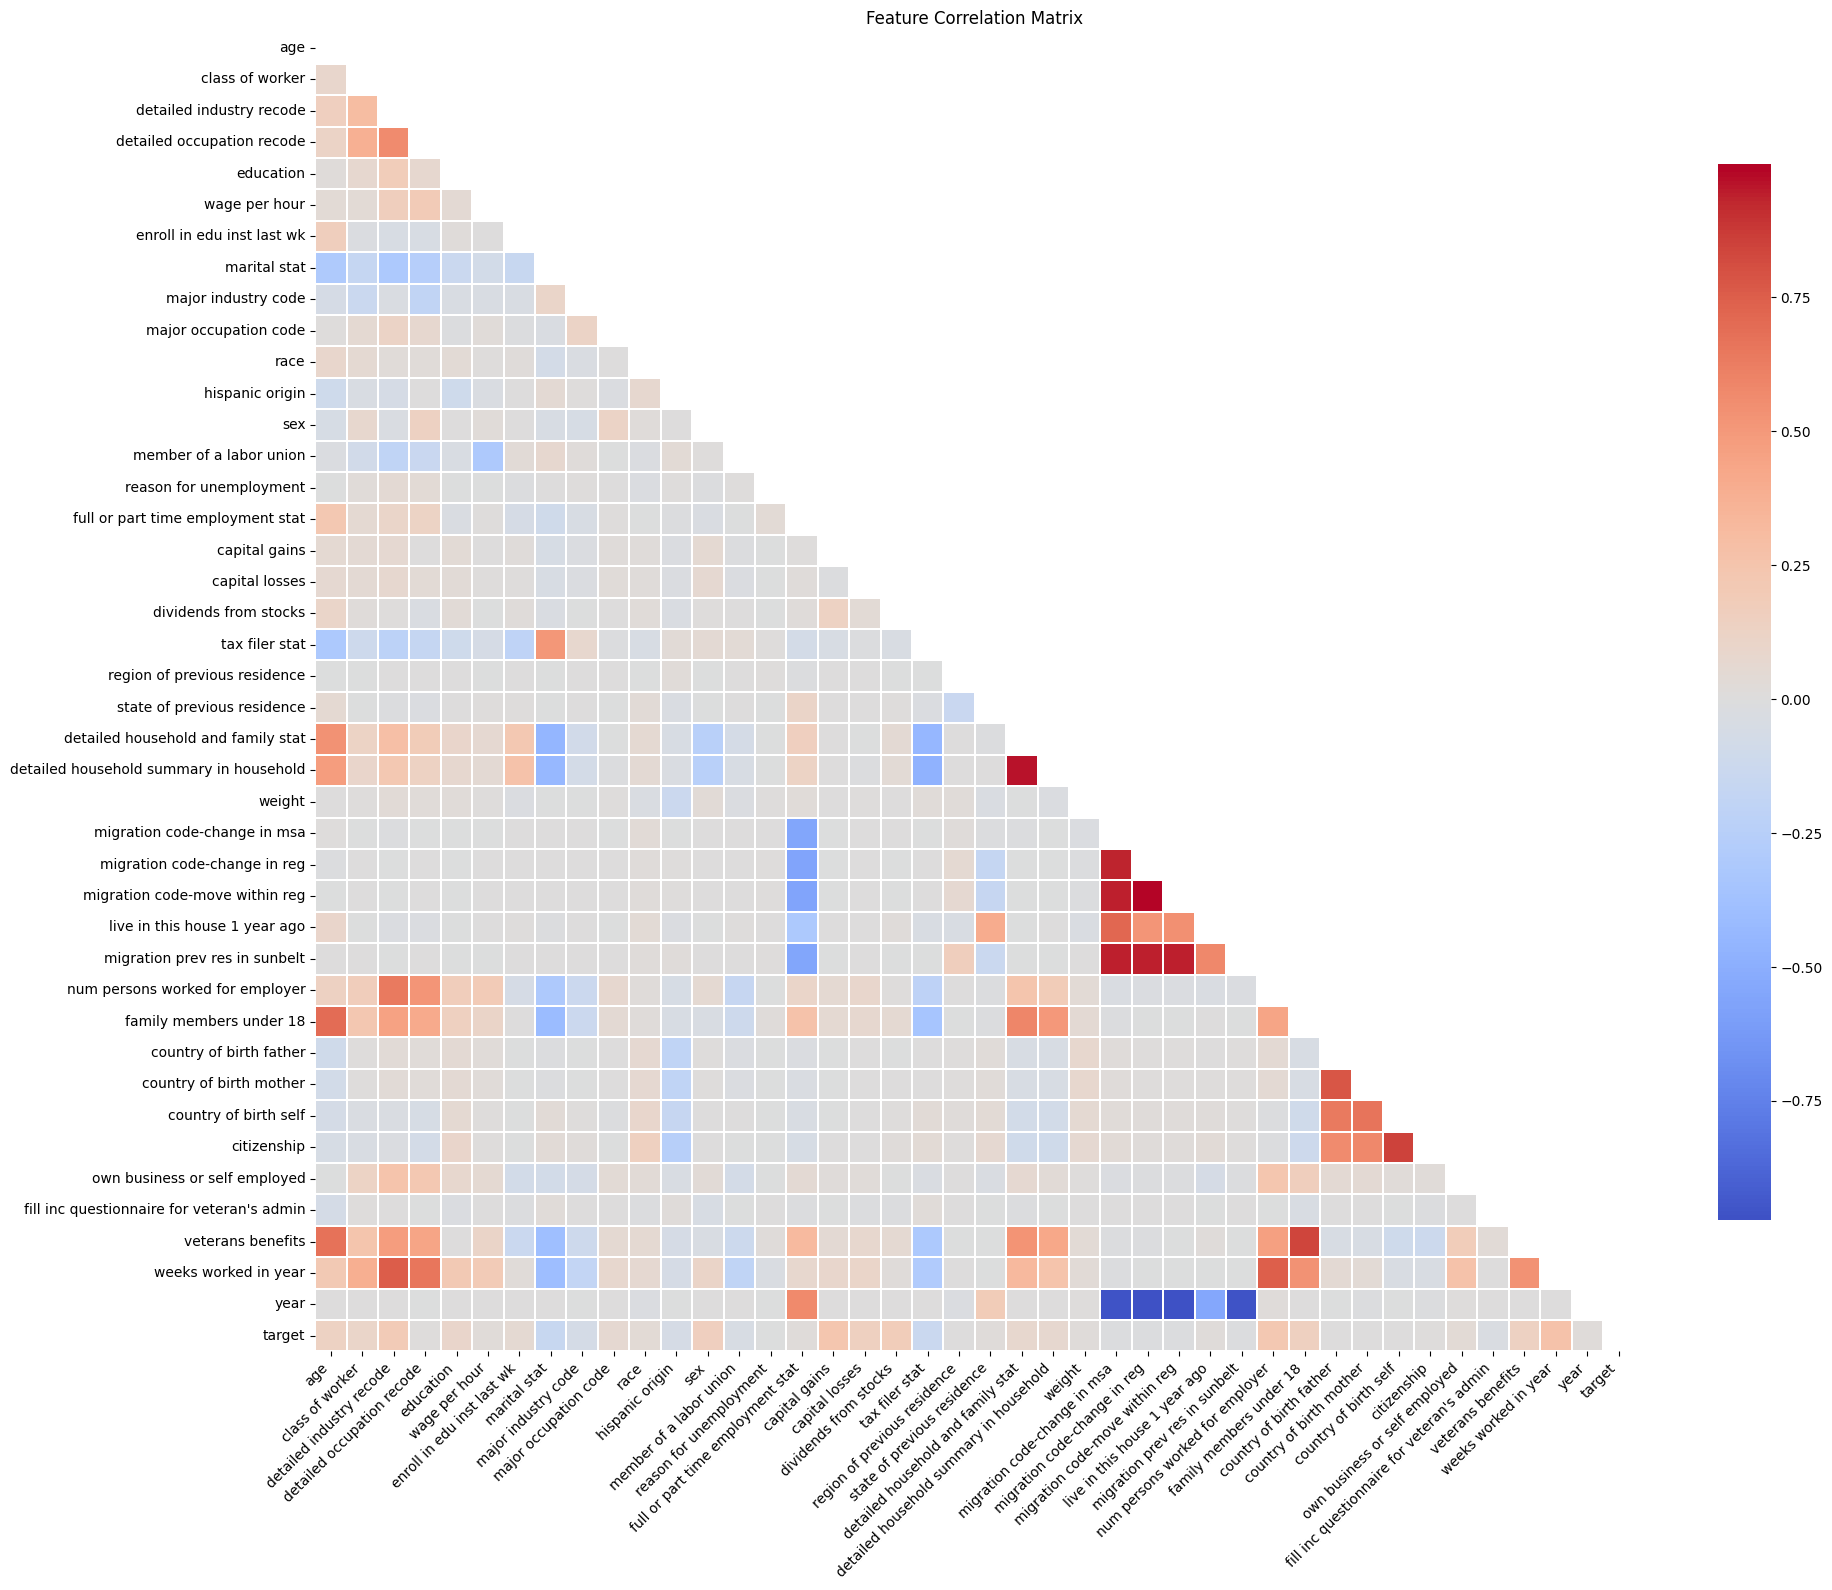

In [14]:
# visualize correlation matrix
plt.figure(figsize=(20, 16))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', center=0, square=True, linewidths=0.1, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


In [15]:
# correlation with target variable
target_correlations = correlation_matrix['target'].abs().sort_values(ascending=False)
target_correlations = target_correlations.drop('target')

print(f"Top 15 Features Most Correlated with Target:")
for feature, corr in target_correlations.head(15).items():
    print(f"  {feature}: {corr:.4f}")


Top 15 Features Most Correlated with Target:
  weeks worked in year: 0.2623
  capital gains: 0.2407
  num persons worked for employer: 0.2227
  detailed industry recode: 0.1962
  dividends from stocks: 0.1758
  sex: 0.1576
  marital stat: 0.1545
  family members under 18: 0.1514
  capital losses: 0.1474
  veterans benefits: 0.1409
  tax filer stat: 0.1377
  age: 0.1357
  class of worker: 0.0998
  education: 0.0981
  detailed household and family stat: 0.0786


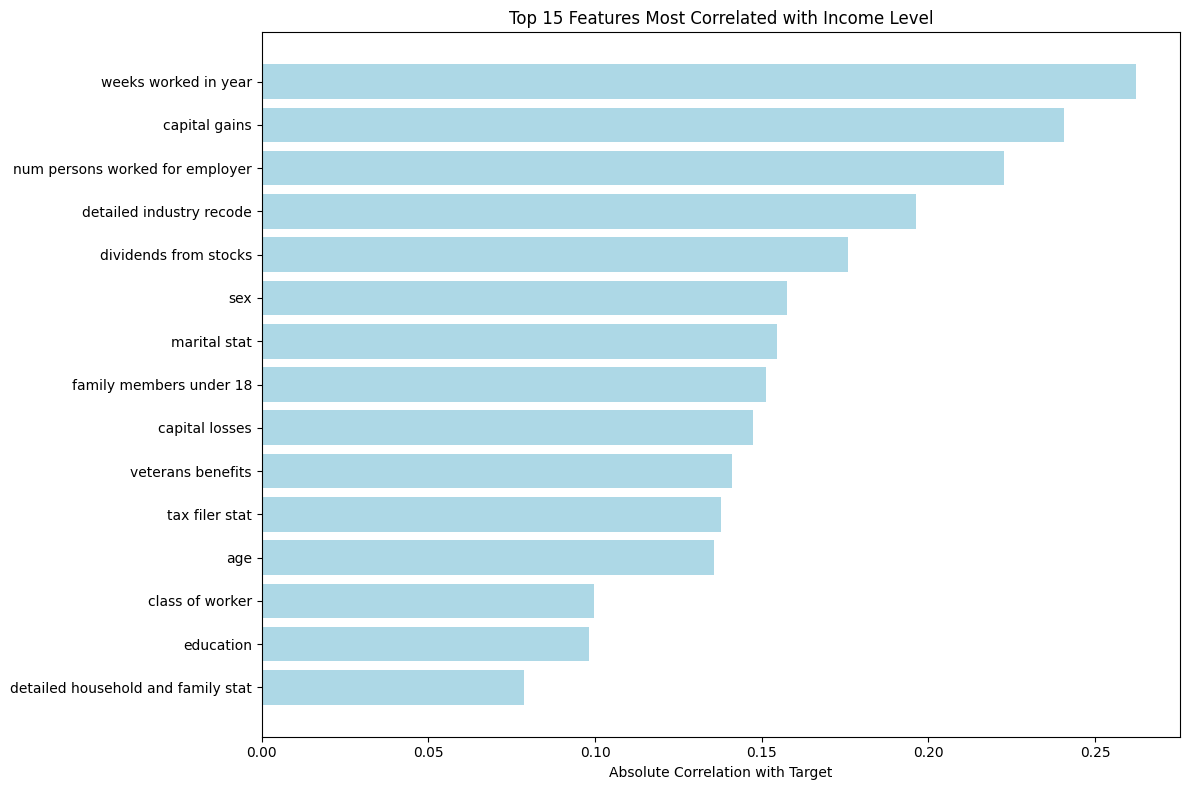

In [16]:
# visualize top correlations with target
plt.figure(figsize=(12, 8))
top_15_corr = target_correlations.head(15)
plt.barh(range(len(top_15_corr)), top_15_corr.values, color='lightblue')
plt.yticks(range(len(top_15_corr)), top_15_corr.index)
plt.xlabel('Absolute Correlation with Target')
plt.title('Top 15 Features Most Correlated with Income Level')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('target_correlations.png', dpi=300, bbox_inches='tight')
plt.show()


5. feature selection

In [17]:
df_encoded = df.copy()
le = LabelEncoder()

categorical_cols = df_encoded.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'label']

for col in categorical_cols:
    df_encoded[col] = df_encoded[col].fillna('Unknown')
    df_encoded[col] = le.fit_transform(df_encoded[col])

X = df_encoded.drop(['label', 'target'], axis=1)
y = df_encoded['target']

# Chi-square test for categorical features
chi2_scores, chi2_pvals = chi2(X, y)
chi2_results = pd.DataFrame({
    'feature': X.columns,
    'chi2_score': chi2_scores,
    'chi2_pval': chi2_pvals
}).sort_values('chi2_score', ascending=False)

print("Top 15 Features by Chi-square Score:")
for _, row in chi2_results.head(15).iterrows():
    print(f"  {row['feature']}: {row['chi2_score']:.2f} (p-value: {row['chi2_pval']:.2e})")
    


Top 15 Features by Chi-square Score:
  capital gains: 586898877.91 (p-value: 0.00e+00)
  dividends from stocks: 122871165.91 (p-value: 0.00e+00)
  capital losses: 8590610.60 (p-value: 0.00e+00)
  weeks worked in year: 353029.91 (p-value: 0.00e+00)
  wage per hour: 163659.07 (p-value: 0.00e+00)
  detailed industry recode: 163285.43 (p-value: 0.00e+00)
  age: 53035.77 (p-value: 0.00e+00)
  num persons worked for employer: 28292.31 (p-value: 0.00e+00)
  weight: 23682.17 (p-value: 0.00e+00)
  detailed household and family stat: 8021.63 (p-value: 0.00e+00)
  family members under 18: 3864.47 (p-value: 0.00e+00)
  hispanic origin: 3778.69 (p-value: 0.00e+00)
  education: 3246.85 (p-value: 0.00e+00)
  marital stat: 3142.91 (p-value: 0.00e+00)
  sex: 2583.05 (p-value: 0.00e+00)


In [18]:
# F-statistic for numerical features
f_scores, f_pvals = f_classif(X, y)
f_results = pd.DataFrame({
    'feature': X.columns,
    'f_score': f_scores,
    'f_pval': f_pvals
}).sort_values('f_score', ascending=False)

print(f"\nTop 15 Features by F-statistic:")
for _, row in f_results.head(15).iterrows():
    print(f"  {row['feature']}: {row['f_score']:.2f} (p-value: {row['f_pval']:.2e})")
    


Top 15 Features by F-statistic:
  weeks worked in year: 14743.49 (p-value: 0.00e+00)
  capital gains: 12273.14 (p-value: 0.00e+00)
  num persons worked for employer: 10410.10 (p-value: 0.00e+00)
  detailed industry recode: 7987.07 (p-value: 0.00e+00)
  dividends from stocks: 6361.44 (p-value: 0.00e+00)
  sex: 5082.53 (p-value: 0.00e+00)
  marital stat: 4878.77 (p-value: 0.00e+00)
  family members under 18: 4681.19 (p-value: 0.00e+00)
  capital losses: 4432.27 (p-value: 0.00e+00)
  veterans benefits: 4043.03 (p-value: 0.00e+00)
  tax filer stat: 3853.93 (p-value: 0.00e+00)
  age: 3744.15 (p-value: 0.00e+00)
  class of worker: 2005.87 (p-value: 0.00e+00)
  education: 1937.51 (p-value: 0.00e+00)
  detailed household and family stat: 1240.09 (p-value: 8.08e-271)


90

In [32]:
# Check for '?' values (common missing indicator in census data)
print(f"\nChecking for '?' values (missing indicators):")
question_mark_counts = {}
for col in df.columns:
    if df[col].dtype == 'object':
        count = (df[col] == '?').sum()
        if count > 0:
            question_mark_counts[col] = count

if question_mark_counts:
    for col, count in sorted(question_mark_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"  {col}: {count} ({count/len(df)*100:.2f}%)")
else:
    print("No '?' values found")


Checking for '?' values (missing indicators):
  migration code-change in msa: 99696 (49.97%)
  migration code-change in reg: 99696 (49.97%)
  migration code-move within reg: 99696 (49.97%)
  migration prev res in sunbelt: 99696 (49.97%)
  country of birth father: 6713 (3.36%)
  country of birth mother: 6119 (3.07%)
  country of birth self: 3393 (1.70%)
  state of previous residence: 708 (0.35%)


In [20]:
df['migration code-change in msa'].value_counts()

migration code-change in msa
?                   99696
Nonmover            82538
MSA to MSA          10601
NonMSA to nonMSA     2811
Not in universe      1516
MSA to nonMSA         790
NonMSA to MSA         615
Abroad to MSA         453
Not identifiable      430
Abroad to nonMSA       73
Name: count, dtype: int64

In [21]:
# Mutual information
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_results = pd.DataFrame({
    'feature': X.columns,
    'mutual_info': mi_scores
}).sort_values('mutual_info', ascending=False)

print(f"\nTop 15 Features by Mutual Information:")
for _, row in mi_results.head(15).iterrows():
    print(f"  {row['feature']}: {row['mutual_info']:.4f}")
    


Top 15 Features by Mutual Information:
  detailed occupation recode: 0.0645
  education: 0.0628
  major occupation code: 0.0607
  veterans benefits: 0.0536
  family members under 18: 0.0518
  weeks worked in year: 0.0516
  major industry code: 0.0499
  class of worker: 0.0480
  fill inc questionnaire for veteran's admin: 0.0463
  tax filer stat: 0.0459
  reason for unemployment: 0.0457
  enroll in edu inst last wk: 0.0451
  race: 0.0417
  country of birth self: 0.0410
  detailed household and family stat: 0.0409


In [29]:
df.columns

Index(['age', 'class of worker', 'detailed industry recode',
       'detailed occupation recode', 'education', 'wage per hour',
       'enroll in edu inst last wk', 'marital stat', 'major industry code',
       'major occupation code', 'race', 'hispanic origin', 'sex',
       'member of a labor union', 'reason for unemployment',
       'full or part time employment stat', 'capital gains', 'capital losses',
       'dividends from stocks', 'tax filer stat',
       'region of previous residence', 'state of previous residence',
       'detailed household and family stat',
       'detailed household summary in household', 'weight',
       'migration code-change in msa', 'migration code-change in reg',
       'migration code-move within reg', 'live in this house 1 year ago',
       'migration prev res in sunbelt', 'num persons worked for employer',
       'family members under 18', 'country of birth father',
       'country of birth mother', 'country of birth self', 'citizenship',
       'ow

In [31]:
df['major occupation code']

0                             Not in universe
1         Precision production craft & repair
2                             Not in universe
3                             Not in universe
4                             Not in universe
                         ...                 
199518                        Not in universe
199519         Executive admin and managerial
199520                        Not in universe
199521                        Not in universe
199522                          Other service
Name: major occupation code, Length: 199523, dtype: object